[View in Colaboratory](https://colab.research.google.com/github/abhigoogol/Autoencoders-using-Pytorch/blob/master/Autoencoder.ipynb)

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print("GPU: ", torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x563af8076000 @  0x7fc0ac3191c4 0x563a9d4ba0d8 0x563a9d5a3d5d 0x563a9d4cd77a 0x563a9d4d2462 0x563a9d4cab3a 0x563a9d4d282e 0x563a9d4cab3a 0x563a9d4d282e 0x563a9d4cab3a 0x563a9d4d282e 0x563a9d4cab3a 0x563a9d4d2e1f 0x563a9d4cab3a 0x563a9d4d282e 0x563a9d4cab3a 0x563a9d4d282e 0x563a9d4d2462 0x563a9d4d2462 0x563a9d4cab3a 0x563a9d4d2e1f 0x563a9d4d2462 0x563a9d4cab3a 0x563a9d4d2e1f 0x563a9d4cab3a 0x563a9d4d2e1f 0x563a9d4cab3a 0x563a9d4d282e 0x563a9d4cab3a 0x563a9d4fb50f 0x563a9d4f6202
0.4.0
('GPU: ', True)


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [60]:
# Courtesy : https://github.com/GunhoChoi
!wget --header="Host: raw.githubusercontent.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://raw.githubusercontent.com/GunhoChoi/Kind-PyTorch-Tutorial/master/06_Autoencoder_Model_Save/model/autoencoder.pkl" -O "autoencoder.pkl" -c


Redirecting output to ‘wget-log’.


In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8
learning_rate = 0.01

In [4]:
traindataset = datasets.MNIST("./", train=True, download=True, transform=transform)
testdataset = datasets.MNIST("./", train=False, download=True, transform=transform)

Processing...
Done!


In [0]:
traindataloader = DataLoader(traindataset, shuffle=True, batch_size=batch_size, num_workers=8)

## Encoder-Decoder

In [0]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(16),
                               nn.Conv2d(16, 32, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(32),
                               nn.Conv2d(32, 64, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(64),
                               nn.MaxPool2d(2, 2))
    self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                               nn.ReLU(),
                               nn.BatchNorm2d(128),
                               nn.MaxPool2d(2, 2),
                               nn.Conv2d(128, 256, 3, padding=1),
                               nn.ReLU())
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size, -1)
    return out

encoder = Encoder().cuda()

In [0]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.layer1 = nn.Sequential(nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(128),
                                nn.ConvTranspose2d(128, 64, 3, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(64))
    self.layer2 = nn.Sequential(nn.ConvTranspose2d(64, 16, 3, 1, 1),
                                nn.ReLU(),
                                nn.BatchNorm2d(16),
                                nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
                                nn.ReLU())
  def forward(self, x):
    out = x.view(batch_size, 256, 7, 7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

decoder = Decoder().cuda()

In [24]:
parameters = list(encoder.parameters()) + list(decoder.parameters())
len(parameters)

32

In [0]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [42]:
traindataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [0]:
try:
	encoder, decoder = torch.load('autoencoder.pkl')
	print("\n--------Model Loaded--------\n")
except:
  print("No file")
  pass

In [69]:
for i in range(6):
  for image, label in traindataloader:
    image = Variable(image).cuda()
    optimizer.zero_grad()
    output = encoder(image)
    output = decoder(output)
    loss = loss_fn(output, image)
    loss.backward()
    optimizer.step()
  if i % 2 == 0:
    torch.save([encoder,decoder],'autoencoder.pkl')
    print(loss)

tensor(0.8272, device='cuda:0')
tensor(0.8368, device='cuda:0')
tensor(0.8515, device='cuda:0')


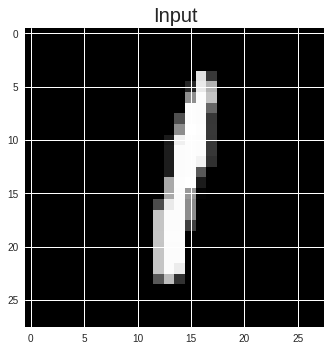

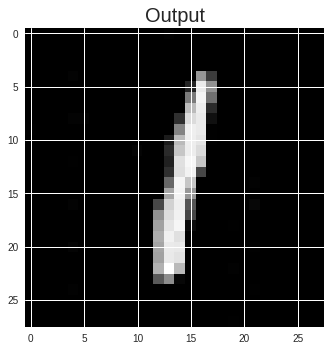

In [74]:
input_img = image[0].cpu()
output_img = output[0].cpu()

inp = input_img.data.numpy()
out = output_img.data.numpy()

plt.title("Input", fontsize=20)
plt.imshow(inp[0],cmap='gray')
plt.show()

plt.title("Output", fontsize=20)
plt.imshow(out[0],cmap="gray")
plt.show()
